# Neuroscience Simulation

This notebook explores certain neuroscience simulations. These are implemented _as is_ in this Jupyter notebook including simulation analysis and different other methodological processes. Implemented simulations include:

1. Neuron Spiking Behaviour - Modelling how neurons spike and fire based on Izhikevich' work.
2. Mammalian Cortex Synchronisation - Modelling a network of neurons and subsequent synchronisation

### Simulation Environment

In [339]:
import random
from enum import StrEnum

import tqdm
import plotly
import numpy as np
import mplcyberpunk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

plt.style.use(["seaborn-v0_8-notebook", "cyberpunk"])

## Neuron Spiking Behaviour

### Neuron Definition

In [9]:
class NeuronName(StrEnum):
    """
    Neurons have an identifier name in line with Izhikevich's analysis of different
    spike behaviours. Each name corresponds to a specific neuron spike condition set.
    """

    RS = "Regular Spiking"
    IB = "Intrinsically Bursting"
    CH = "Chattering"
    FS = "Fast Spiking"
    LTS = "Low-Threshold Spiking"
    TC = "Thalamo-Cortical"
    RZ = "Resonator"


class NeuronType(StrEnum):
    """
    Neurons have a categorical type. These types describe the biological nature of the
    neuron with respect to how the activity impacts cortical behaviour.
    """

    Excitatory = "Excitatory"
    Inhibitory = "Inhibitory"
    Other = "Other"


class Neuron:
    def __init__(
        self,
        name: NeuronName,
        dtype: NeuronType,
        recovery_time_scale: float,
        recovery_sensitivity: float,
        reset_potential: float,
        reset_recovery: float,
    ):
        """
        A neuron for the STDP case study is assessed for membrane potential activations
        over a simulated time-delta. Attributes of this instance describe additional
        behaviours of this neuron as the membrane potential and recovery variable change
        over time.

        Args:
            name (NeuronName): Name of the neuron.
            dtype (NeuronType): Type of the neuron.
            recovery_time_scale (float): Time-scale of recovery variable.
            recovery_sensitivity (float): Sensitivity of recovery variable.
            reset_potential (float): Spike reset of membrane potential.
            reset_recovery (float): Spike reset of recovery variable.
        """
        self.name: NeuronName = name
        self.dtype: NeuronType = dtype
        self._recovery_time_scale: float = recovery_time_scale
        self._recovery_sensitivity: float = recovery_sensitivity
        self._reset_potential: float = reset_potential
        self._reset_recovery: float = reset_recovery

    def __eq__(self, other) -> bool:
        return self.name == other.name

    def __hash__(self) -> int:
        return hash(self.name)

    def get_name(self) -> str:
        return self.name.value

    def get_dtype(self) -> str:
        return self.dtype.value

    def get_recovery_time_scale(self) -> float:
        return self._recovery_time_scale

    def get_recovery_sensitivity(self) -> float:
        return self._recovery_sensitivity

    def get_reset_potential(self) -> float:
        return self._reset_potential

    def get_reset_recovery(self) -> float:
        return self._reset_recovery

### Neuron Spiking Simulation

In [133]:
# Neuron behaviour constants
NEURON_INITIAL_POTENTIAL: float = -70.0
NEURON_INITIAL_RECOVERY: float = 0.0
NEURON_THRESHOLD: float = 30.0
NEURON_CURRENT: float = 10.0

# Neuron simulation constants
NEURON_CURRENT_DELAY_MS: int = 10
NEURON_STIMULI_DELAY_MS: int = 50
NEURON_RESONANCE_DELAY_MS: int = 50

# Neurons according to Izhikevich
NEURON_LIST: list[Neuron] = [
    Neuron(NeuronName.RS,   NeuronType.Excitatory,  0.02, 0.20, -65, 8.00),
    Neuron(NeuronName.IB,   NeuronType.Excitatory,  0.02, 0.20, -55, 4.00),
    Neuron(NeuronName.CH,   NeuronType.Excitatory,  0.02, 0.20, -50, 2.00),
    Neuron(NeuronName.FS,   NeuronType.Inhibitory,  0.10, 0.20, -65, 2.00),
    Neuron(NeuronName.LTS,  NeuronType.Inhibitory,  0.02, 0.25, -65, 2.00),
    Neuron(NeuronName.TC,   NeuronType.Other,       0.02, 0.25, -65, 0.05),
    Neuron(NeuronName.RZ,   NeuronType.Other,       0.10, 0.26, -65, 2.00),
]

In [138]:
class NeuronSpikingSimulation:
    @staticmethod
    def step_potential(potential: float, recovery: float, current: float) -> float:
        """
        Update function for a delta time-step of the neuron membrane potential based on
        the previous step value. This uses Izhikevich's formulation of the differential
        equation for the membrane potential.

        $$
        \\frac{dv}{dt} &= 0.04v^2 + 5v + 140 -u + I
        $$

        Args:
            potential (float): Previous updated membrane potential.
            recovery (float): Previous updated recovery variable.
            current (float): Post-synaptic input current.

        Returns:
            float: Delta time-step membrane potential from Izhikevich's formula.
        """
        return (0.04 * potential**2) + (5 * potential) + 150 - recovery + current

    @staticmethod
    def step_recovery(neuron: Neuron, potential: float, recovery: float) -> float:
        """
        Update function for a delta time-step of the neuron recovery based on the
        previous step value. This uses Izhikevich's formulation of the differential
        equation for the recovery variable.

        $$
        \\frac{du}{dt} &= a(bv-u)
        $$

        Args:
            neuron (Neuron): Neuron container for required hyperparameters.
            potential (float): Previous updated membrane potential.
            recovery (float): Previous updated recovery variable.

        Returns:
            float: Delta time-step recovery from Izhikevich's formula.
        """
        recovery_time_scale = neuron.get_recovery_time_scale()
        recovery_sensitivity = neuron.get_recovery_sensitivity()
        return recovery_time_scale * (recovery_sensitivity * potential - recovery)

    @staticmethod
    def simulate_neuron_spiking(
        neuron: Neuron,
        ms_total: int = 1000,
        ms_timestep: float = 0.1,
        initial_potential: float = NEURON_INITIAL_POTENTIAL,
        initial_recovery: float = NEURON_INITIAL_RECOVERY,
        current: float = NEURON_CURRENT,
        brief_stimulus: bool = False,
        negative_resonance: bool = False,
    ) -> pd.DataFrame:
        """
        Simulate the changing membrane potential and recovery variable for an individual
        neuron and given time conditions/input current. This simulation will make time-
        steps based on Izhikevich's differential equations.

        Args:
            neuron (Neuron): Neuron conditions to assess.
            ms_total (int, optional): Millisecond simulation time. Defaults to 1000.
            ms_timestep (float, optional): Millisecond delta time-step. Defaults to 0.1.
            initial_potential (float, optional): Starting membrane potential.
                Defaults to NEURON_INITIAL_MEMBRANE_POTENTIAL.
            initial_recovery (float, optional): Starting recovery variable.
                Defaults to NEURON_INITIAL_RECOVERY.
            current (float, optional): Input current for the update step differntial 
                equations. Defaults to NEURON_INPUT_CURRENT.
            brief_stimulus (bool, optional): Flag for applying stimuli at a set time.
                Defaults to False.
            negative_resonance (bool, optional): Flag for applying a negative current
                for the starting time period. Defaults to False.

        Returns:
            pd.DataFrame: DataFrame of simulation results. Rows correspond to time step
                with columns for simulation time, membrane potential, and recovery.
        """

        # Calculate number of simulation steps
        steps = int(ms_total / ms_timestep)

        # Setup containers for recording time-step values
        times = np.zeros(steps, dtype=np.float32)
        potential_array = np.zeros(steps, dtype=np.float32)
        potential_array[0] = initial_potential
        recovery_array = np.zeros(steps, dtype=np.float32)
        recovery_array[0] = initial_recovery

        # Cycle through the simulation steps and perform updates
        stimulus_delay = 0
        for index in tqdm.tqdm(range(1, steps), desc="Neuron Spiking Simulation"):
            # Set the input current based on the simulation time
            inp_current = 0 if times[index - 1] < NEURON_CURRENT_DELAY_MS else current
            
            # Apply negative resonance
            if negative_resonance:
                if times[index - 1] < NEURON_CURRENT_DELAY_MS:
                    inp_current = -1 * current
                else: 
                    inp_current = 0

            # Apply a stimulus
            if brief_stimulus and times[index - 1] % NEURON_STIMULI_DELAY_MS < 1:
                stimulus_delay = 1
            if stimulus_delay > 0 and stimulus_delay <= 5:
                stimulus_delay += 1
                inp_current += current
            else: 
                stimulus_delay = 0

            # Obtain previous values from last time-step
            prev_potential = potential_array[index - 1]
            prev_recovery = recovery_array[index - 1]

            # Account for threshold updates
            if prev_potential >= NEURON_THRESHOLD:
                reset_potential = neuron.get_reset_potential()
                potential_array[index] = reset_potential
                reset_recovery = neuron.get_reset_recovery()
                recovery_array[index] = prev_recovery + reset_recovery

            # Otherwise perform normal variable updates
            else:
                new_potential = NeuronSpikingSimulation.step_potential(
                    prev_potential, prev_recovery, inp_current
                )
                new_recovery = NeuronSpikingSimulation.step_recovery(
                    neuron, prev_potential, prev_recovery
                )
                potential_array[index] = prev_potential + ms_timestep * new_potential
                recovery_array[index] = prev_recovery + ms_timestep * new_recovery

            # Update the time array
            times[index] = times[index - 1] + ms_timestep

        return pd.DataFrame(
            {
                "Time": times,
                "Potential": potential_array,
                "Recovery": recovery_array,
            }
        )

### Simulation Analysis

Neuron Spiking Simulation:   0%|          | 0/9999 [00:00<?, ?it/s]

Neuron Spiking Simulation: 100%|██████████| 9999/9999 [00:00<00:00, 71206.13it/s]


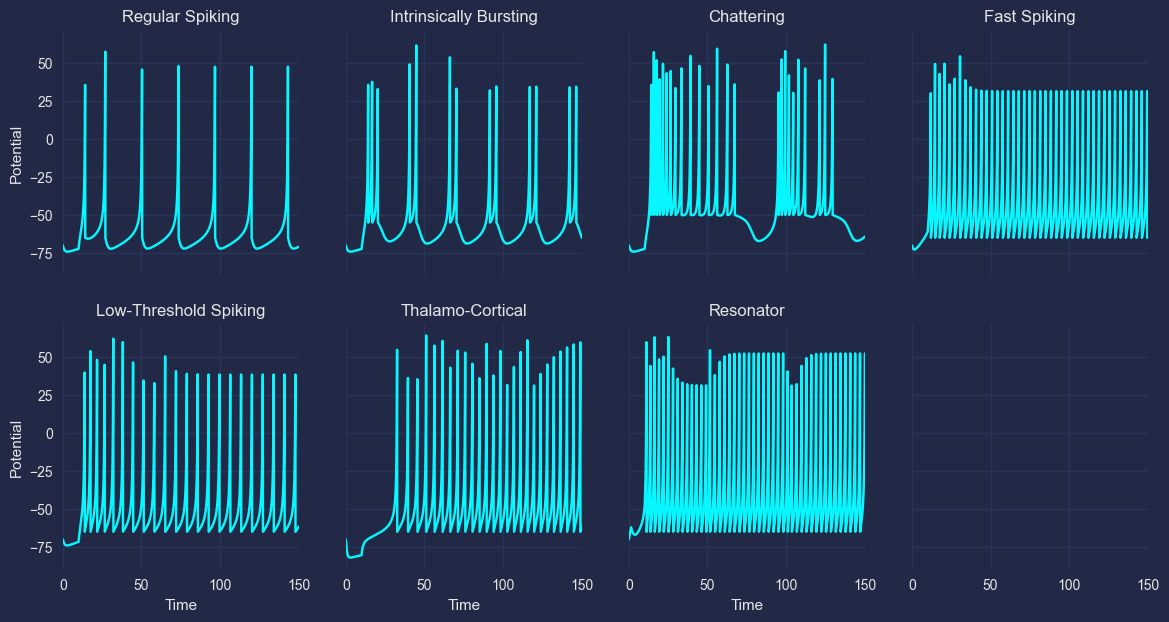

In [340]:
# Prepare the simulation dataframe
res = [
    NeuronSpikingSimulation.simulate_neuron_spiking(
        n, 
        brief_stimulus=True if n.name == "Resonator" else False,
        negative_resonance=True if n.name == "Thalamo-Cortical" else False,
    ) 
    for n in NEURON_LIST
]
res = [(n, d) for n, d in zip(NEURON_LIST, res)]
for neuron, df in res:
    df["Neuron"] = neuron.name
    df["Type"] = neuron.dtype
res = pd.concat([d for n, d in res], axis=0)

# Plot the output spiking behaviour
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(14,7))
for i in range(len(NEURON_LIST)):
    c, r = i % 4, i // 4
    df = res[res.Neuron == NEURON_LIST[i].name]
    sns.lineplot(ax=axes[(r,c)], data=df, x="Time", y="Potential")
    axes[(r,c)].set_title(NEURON_LIST[i].name)
    axes[(r,c)].set_xlim((0, 150))

## Mamallian Cortex Synchronisation

### Cortex Synchronisation Simulation

In [353]:
class CotexSynchronisationSimulation:
    @staticmethod
    def simulate_cortex_synchronisation(
        Ne: int = 800, 
        Ni: int = 200, 
        ms_total: int = 1000
    ) -> pd.DataFrame:
        """
        Perform a simulation of cortex activity to determine how neurons attain
        synchronisation over some period of time. This implementation follows that
        provided by Izhikevich. Note that a fixed 1ms time-step is used.

        Args:
            Ne (int, optional): Number of excitatory neurons. Defaults to 800.
            Ni (int, optional): Number of inhibitory neurons. Defaults to 200.
            ms_total (int, optional): Simulation time in milliseconds. Defaults to 1000.

        Returns:
            pd.DataFrame: Results from the simulation with column pair of the time of
                a neuron spiking and the respective neuron index.            
        """    
        # Create random excitatory and inhibitory neurons
        re = np.random.random(Ne)
        ri = np.random.random(Ni)

        # Initialise respective hyperparameter behaviours for each group
        a = np.concatenate([0.02 * np.ones(Ne), 0.02 + 0.08 * ri])
        b = np.concatenate([0.2  * np.ones(Ne), 0.25 - 0.05 * ri])
        c = np.concatenate([-65 + 15 * re ** 2, -65 * np.ones(Ni)])
        d = np.concatenate([8 - 6 * re ** 2, 2 * np.ones(Ni)])

        # Create random behaviours for the input current
        S = np.concatenate([0.5 * np.random.random((Ne + Ni, Ne)), 
                            -1 * np.random.random((Ne + Ni, Ne + Ni))], axis=1)
        
        # Initialise update variables for the potential and recovery
        v = -65 * np.ones(Ne + Ni)
        u = b * v

        # Simulate for the given time period
        firings = None
        for t in range(1000):
            # Calculate the input current for this time-step
            I = np.concatenate([5 * np.random.normal(size=Ne), 
                                2 * np.random.normal(size=Ni)])
            
            # Isolate fired neurons and reset them
            fired = np.where(v >= 30)[0]
            timings = np.stack([t + 0 * fired, fired], axis=1)
            if firings is None:
                firings = timings
            else:
                firings = np.append(firings, timings, axis=0)
            v[fired] = c[fired]
            u[fired] = u[fired] + d[fired]

            # Update the potentials and recoveries for each neuron
            I = I + S[:,fired].sum(axis=1)
            v = v + 0.5 * (0.04 * v ** 2 + 5 * v + 140 - u + I)
            v = v + 0.5 * (0.04 * v ** 2 + 5 * v + 140 - u + I)
            u = u + a * (b * v - u)   
        return pd.DataFrame(firings, columns=["Time (ms)", "Neuron Number"])

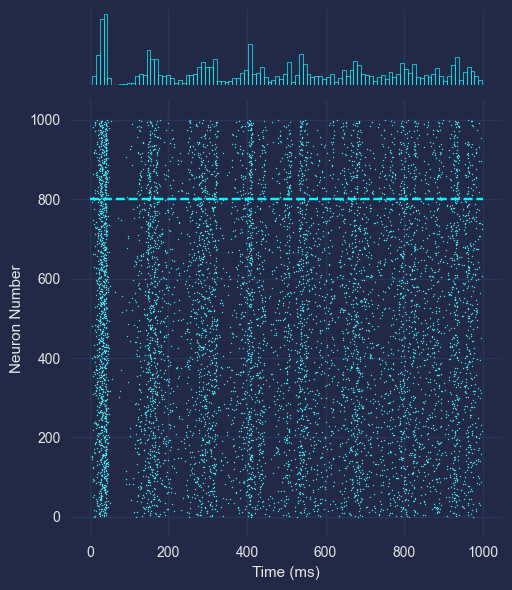

In [354]:
res = CotexSynchronisationSimulation.simulate_cortex_synchronisation()
g = sns.jointplot(data=res, 
                  x="Time (ms)", 
                  y="Neuron Number", 
                  s=0.75, 
                  marginal_kws=dict(bins=100, fill=False), 
                  legend=False)
plt.plot([0, 1000], [800, 800], linestyle="--")
g.ax_marg_y.remove()